# Initialization

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from math import ceil
from statistics import median

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tfk.layers

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
DATASET_FILE = '/dataset/dataset.csv'

# Decide whether to use scaling or normalization
USE_MIN_MAX_NORM = 'MinMax'    # Interval: [0:1]
USE_MEAN_STD_SCALE = 'MeanStd'

FREQUENCY = 96    # Relevant frequency to build additional sin and cos columns
ADD_SIN = True    # Flags to decide which columns to add to the dataset
ADD_COS = True

BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
TRAIN_BATCH_PER_EPOCH = 10000
VAL_BATCH_PER_EPOCH = 500
TELESCOPE = 96
WINDOW_SIZE = 96*3
STRIDE = int((WINDOW_SIZE + TELESCOPE) / 20)
CONST_THRESHOLD = 0.1    # Maximum fraction of telescope values that can be corrupted whithin a window
MIN_CONST_NUM = 10    # Minimum number of successive constant samples to consider a signal corrupted

TARGET_LABELS = ['Sponginess',
                  'Wonder level',
                  'Crunchiness',
                  'Loudness on impact',
                  'Meme creativity',
                  'Soap slipperiness',
                  'Hype root']

TRAINING_LABELS = ['Sponginess',
                  'Wonder level',
                  'Crunchiness',
                  'Loudness on impact',
                  'Meme creativity',
                  'Soap slipperiness',
                  'Hype root',
                  'freq_sin',
                  'freq_cos']

DEBUG = False

# Dataset preparation

In [ ]:
df = pd.read_csv(DATASET_FILE).astype('float32')    # Cast necessary?
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 1.8 MB


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000,68528.000000
mean,6.093986,4.695582,13.337390,2.448718,2.407179,23.237875,8.231431
std,1.941717,3.374214,11.702990,3.001717,0.994042,14.297975,11.285133
min,-0.972080,-8.450379,-37.581722,-9.028060,-1.275860,-6.006860,-42.769222
25%,4.791440,2.223420,10.672820,0.468800,2.112200,12.560241,6.604160
50%,5.702780,4.668600,15.676060,2.533840,2.618500,20.151419,10.968300
75%,7.067300,7.115440,20.568081,4.656980,3.021880,31.245199,15.334101
max,15.106680,18.122900,41.138802,14.035980,6.056360,77.371620,31.024420


In [ ]:
# Plots the columns of the dataset in the range 'plt_range'

# Intresting ranges
# plt_range=(37000,38000) Sponginess flatline
# plt_range=(15000,15500) All signals flatline
# plt_range=(0,10000)

def inspect_dataframe(df, columns=None, plt_range=None, line_width=0.3):
    if columns is None:
        columns = df.columns
    if plt_range is None:
        plt_range = (0,len(df))
    plt.rcParams.update({'font.size': 20})
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,30))
    for i, col in enumerate(columns):
        axs[i].plot(df[col][plt_range[0]:plt_range[1]], linewidth=line_width)
        axs[i].set_title(col)
    plt.show()

In [ ]:
class DataPreprocessor:
    
    def __init__(self,
                 df,
                 val_split = VALIDATION_SPLIT,
                 add_sin  = ADD_SIN,    # Flags to decide which columns to add to the dataset
                 add_cos = ADD_COS,
                 frequency = FREQUENCY,    # Relevant frequency to build additional sin and cos columns
                 scaling_method = USE_MEAN_STD_SCALE):

        self.df = df.copy()
        self.val_split = val_split
        self.add_sin = add_sin
        self.add_cos = add_cos
        self.frequency = frequency
        self.scaling_method = scaling_method
        
        self.add_freq_columns()
        self.tot_n_samples = len(self.df)

        self.train_df = self.df.copy()
        self.n_train_samples = len(self.train_df)

        n_val_samples = int(len(self.df) * val_split)
        n_val_samples = n_val_samples - (n_val_samples % frequency)
        self.val_df = self.df.copy().iloc[-n_val_samples : self.tot_n_samples]
        self.n_val_samples = n_val_samples

        if self.scaling_method != None:
            # Save the scaling parameters
            if self.scaling_method == USE_MIN_MAX_NORM:
                self.scale_p1 = self.train_df.min()
                self.scale_p2 = self.train_df.max()
            elif self.scaling_method == USE_MEAN_STD_SCALE:
                self.scale_p1 = self.train_df.mean()
                self.scale_p2 = self.train_df.std()

            self.scale_dataframe(partition = 'train')
            self.scale_dataframe(partition = 'val')


    # Add columns of sin and cosine with specified frequency
    def add_freq_columns(self):

        temp = [i for i in range(len(self.df))]
        if self.add_sin:
            self.df['freq_sin'] = [np.sin(val * (2 * np.pi / self.frequency)) for val in temp]
        if self.add_cos:
            self.df['freq_cos'] = [np.cos(val * (2 * np.pi / self.frequency)) for val in temp]

    # Normalizes the dataframe wrt the normalization type specified
    def scale_dataframe(self, partition):

        if self.scaling_method == USE_MIN_MAX_NORM:

            df_min = self.scale_p1
            df_max = self.scale_p2

            if partition == 'train':
                self.train_df = (self.train_df-df_min)/(df_max-df_min)
            elif partition == 'val':
                self.val_df = (self.val_df-df_min)/(df_max-df_min)

        elif self.scaling_method == USE_MEAN_STD_SCALE:
            
            df_mean = self.scale_p1
            df_std = self.scale_p2

            if partition == 'train':
                self.train_df = (self.train_df-df_mean)/df_std
            elif partition == 'val':
                self.val_df = (self.val_df-df_mean)/df_std


    def upscale_dataframe(self, partition):

        if self.scaling_method == USE_MIN_MAX_NORM:

            df_min = self.scale_p1
            df_max = self.scale_p2

            if partition == 'train':
                self.train_df = self.train_df * (df_max - df_min) + df_min
            elif partition == 'val':
                self.val_df = self.val_df * (df_max - df_min) + df_min

        elif self.scaling_method == USE_MEAN_STD_SCALE:

            df_mean = self.scale_p1
            df_std = self.scale_p2
            
            if partition == 'train':
                self.train_df = (self.train_df * df_std) + df_mean
            elif partition == 'val':
                self.val_df = (self.val_df * df_std) + df_mean

# Dataset Visualization

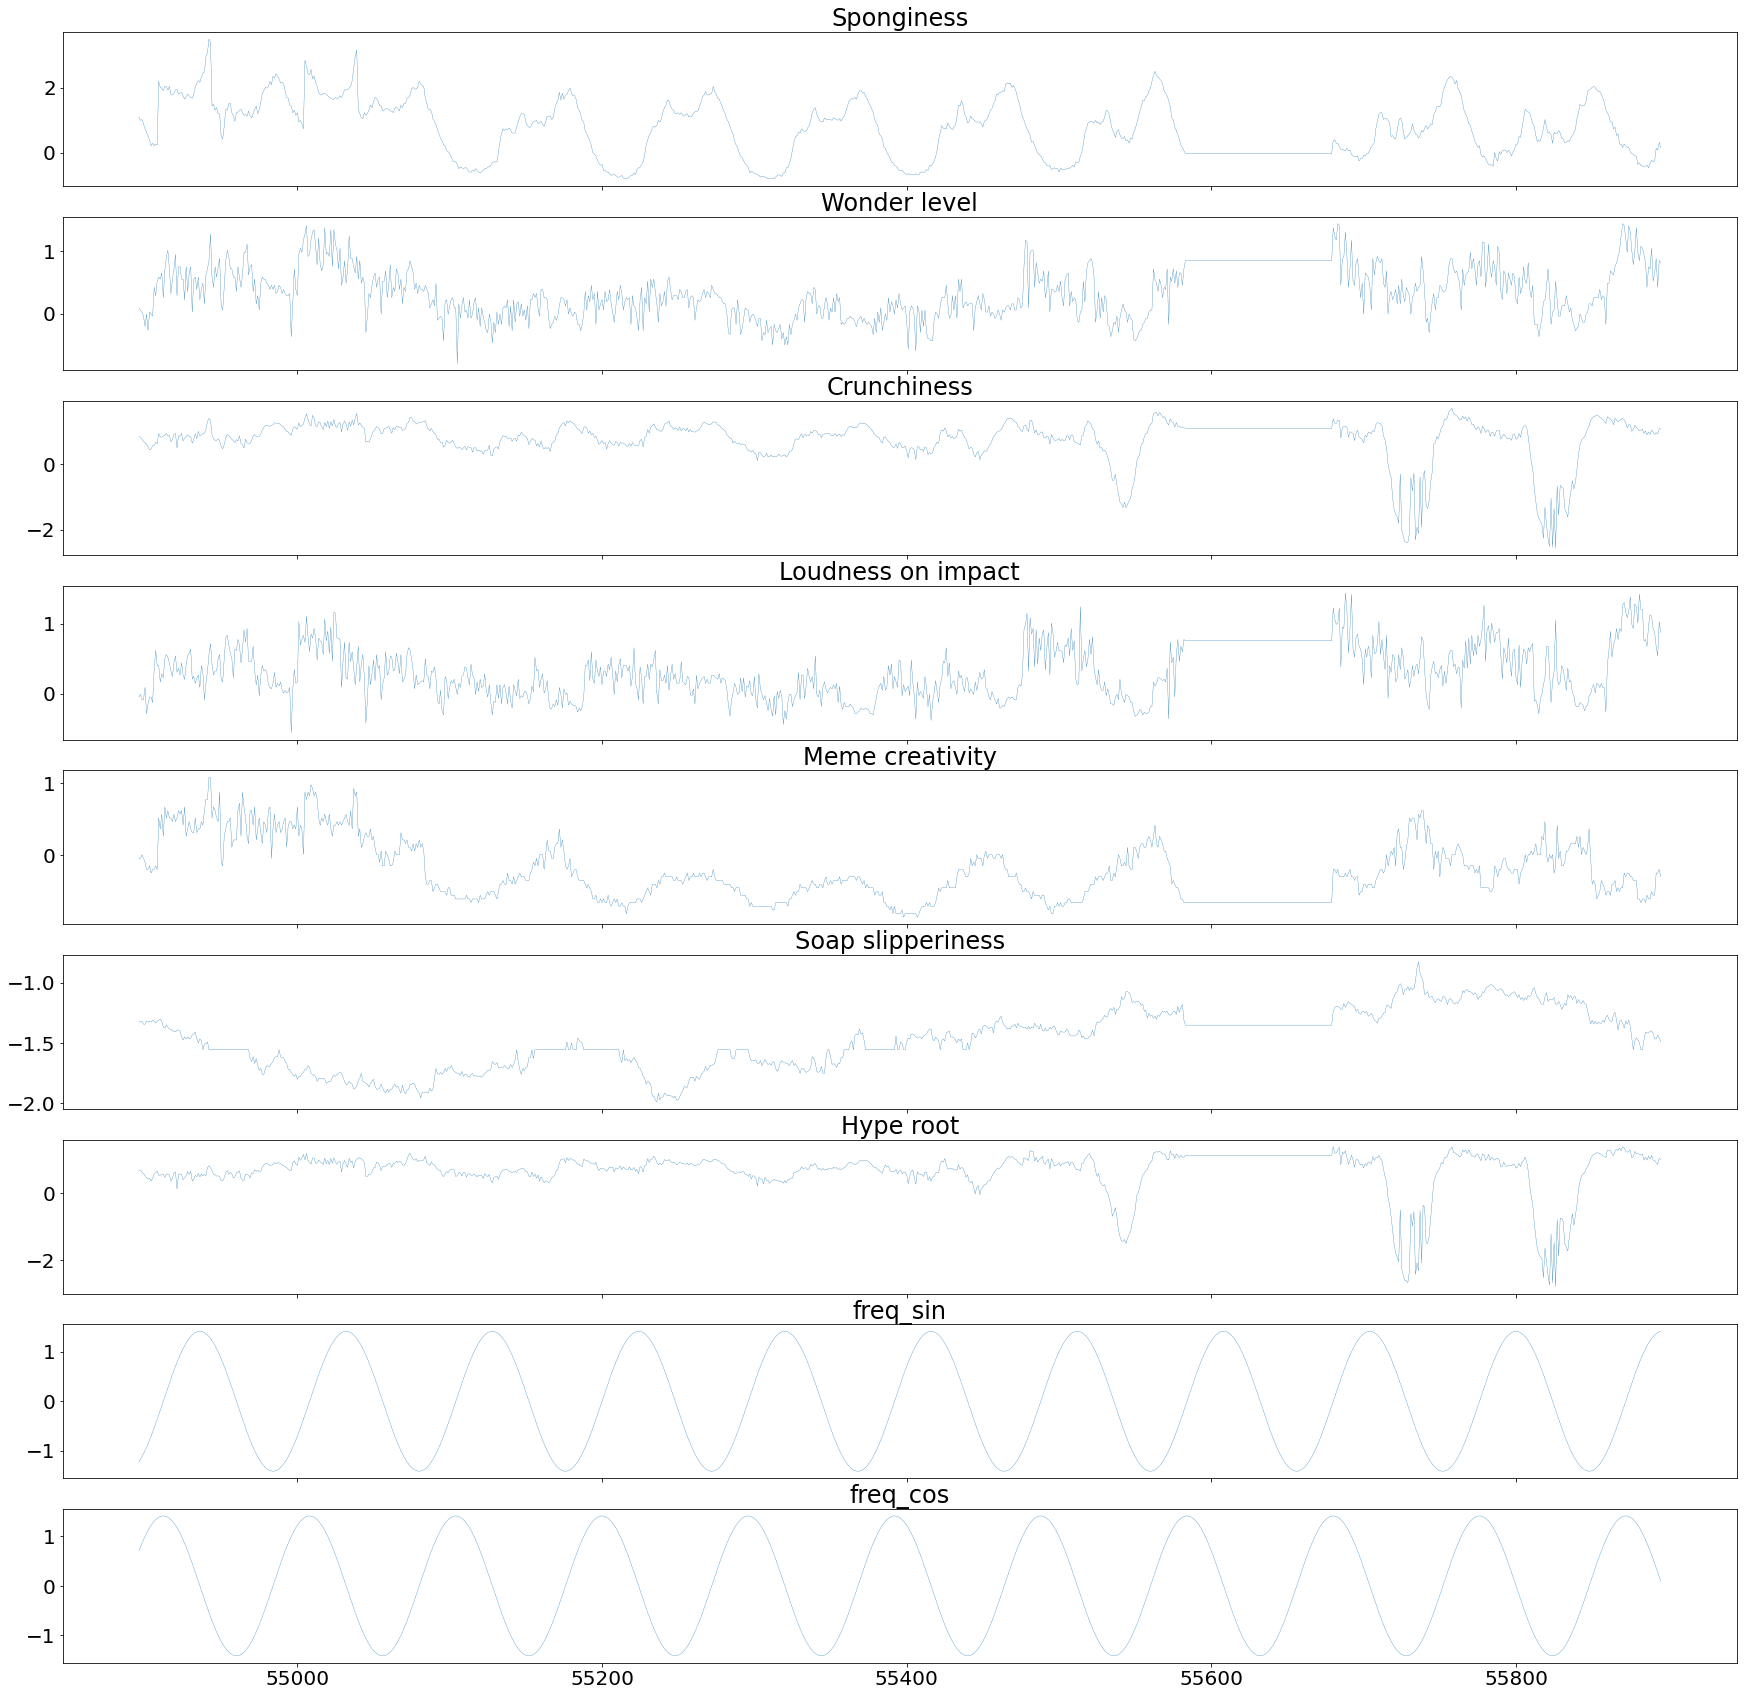

In [ ]:
temp = DataPreprocessor(df, scaling_method=USE_MEAN_STD_SCALE).val_df
inspect_dataframe(temp, temp.columns, plt_range=(0,1000))
temp = None

# Custom Keras SequenceGenerator

In [ ]:
class SequenceGenerator(tfk.utils.Sequence):
    
    def __init__(self,
                 df,
                 input_width = WINDOW_SIZE,
                 output_width = TELESCOPE,
                 stride = STRIDE,
                 train_features = None,
                 target_features = TARGET_LABELS,
                 batch_size = BATCH_SIZE,
                 shuffle = False):
        
        self.df = df
        self.input_width = input_width
        self.output_width = output_width
        self.stride = stride    # distance between beginning of two batches
        self.train_features = train_features if train_features != None else df.columns
        self.target_features = target_features
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n_samples = len(df)
        self.n_samples_per_batch = input_width * batch_size + output_width
        assert self.n_samples >= self.n_samples_per_batch
        self.n_batches = ceil((len(df) - self.n_samples_per_batch) / stride) + 1
        
        
    # returns a touple containing a batch of inputs and their respective targets
    def __getitem__(self, index):
        
        input_df = self.df[self.train_features].values
        target_df = self.df[self.target_features].values
        X = []
        y = []
        
        index = index * self.stride
        last_sample_index = index + self.n_samples_per_batch
        
        if last_sample_index > self.n_samples:
            index = self.n_samples - self.n_samples_per_batch
            
        window_start_indexes = range(index, index + (self.batch_size * self.input_width), self.input_width)
        
        for win_start in window_start_indexes:
            X.append(input_df[win_start : win_start + self.input_width])
            y.append(target_df[win_start + self.input_width : win_start + self.input_width + self.output_width])
        
        X = np.array(X)
        y = np.array(y)
        
        return X, y
        
        
    def __len__(self):
        return self.n_batches
    
    def __repr__(self):
        s = ''
        s += 'input length:\t\t' + str(self.input_width) + '\n'
        s += 'prediction length:\t' + str(self.output_width) + '\n'
        s += 'samples:\t\t' + str(self.n_samples) + '\n'
        s += 'batch size:\t\t' + str(self.batch_size) + '\n'
        s += 'batches:\t\t' + str(self.n_batches) + '\n'
        s += 'stride:\t\t' + str(self.stride) + '\n'

        s += 'training features:\t' + '\n'
        for i, el in enumerate(self.train_features):
            s += '\t' + str(i+1) + ') ' + el + '\n'

        s += 'target features:' + '\n'
        for i, el in enumerate(self.target_features):
            s += '\t' + str(i+1) + ') ' + el + '\n'

        return s

In [ ]:
if DEBUG:
    # Check generator works well

    X_raw = add_freq_columns(df)
    X_raw = normalize_dataframe(X_raw)

    train_gen = SequenceGenerator(X_raw)
    #print(train_gen.n_samples_per_batch)
    print(train_gen)

    # Check on last window
    batch_index = train_gen.__len__()
    for window_index in range(train_gen.batch_size):
        X_train, y_train = train_gen.__getitem__(batch_index)
        X_train = X_train[window_index]

        temp = X_raw.values

        temp = temp[ len(temp) - train_gen.n_samples_per_batch + (window_index * train_gen.input_width) :
                     len(temp) - train_gen.n_samples_per_batch + (window_index * train_gen.input_width) + train_gen.input_width]

        for x, y in zip(X_train,temp):
            for x1, y1 in zip(x,y):
                assert(x1 == y1)
    # Check on all other windows
    for batch_index in tqdm(range(train_gen.__len__()-1)):
        for window_index in range(train_gen.batch_size):
            X_train, y_train = train_gen.__getitem__(batch_index)
            X_train = X_train[window_index]

            temp = X_raw.values

            temp = temp[(batch_index * train_gen.stride) + (window_index * train_gen.input_width) :
                        (batch_index * train_gen.stride) + (window_index * train_gen.input_width) + train_gen.input_width]

            for x, y in zip(X_train,temp):
                for x1, y1 in zip(x,y):
                    assert(x1 == y1)

In [ ]:
if DEBUG:
    for i in tqdm(range(train_gen.__len__())):
        batch = train_gen.__getitem__(i)
        if batch[0].shape != (BATCH_SIZE, WINDOW_SIZE, 9) or batch[1].shape != (BATCH_SIZE, TELESCOPE, 7):
            print(batch[0].shape,batch[1].shape)

    for i in tqdm(range(val_gen.__len__())):
        batch = val_gen.__getitem__(i)
        if batch[0].shape != (BATCH_SIZE, WINDOW_SIZE, 9) or batch[1].shape != (BATCH_SIZE, TELESCOPE, 7):
            print(batch[0].shape,batch[1].shape)

In [ ]:
pre_df = DataPreprocessor(df)

train_gen = SequenceGenerator(pre_df.train_df)
val_gen = SequenceGenerator(pre_df.val_df)

print(train_gen)
print()
print(val_gen)

input length:		288
prediction length:	96
samples:		68528
batch size:		32
batches:		3118
stride:		19
training features:	
	1) Sponginess
	2) Wonder level
	3) Crunchiness
	4) Loudness on impact
	5) Meme creativity
	6) Soap slipperiness
	7) Hype root
	8) freq_sin
	9) freq_cos
target features:
	1) Sponginess
	2) Wonder level
	3) Crunchiness
	4) Loudness on impact
	5) Meme creativity
	6) Soap slipperiness
	7) Hype root


input length:		288
prediction length:	96
samples:		13632
batch size:		32
batches:		229
stride:		19
training features:	
	1) Sponginess
	2) Wonder level
	3) Crunchiness
	4) Loudness on impact
	5) Meme creativity
	6) Soap slipperiness
	7) Hype root
	8) freq_sin
	9) freq_cos
target features:
	1) Sponginess
	2) Wonder level
	3) Crunchiness
	4) Loudness on impact
	5) Meme creativity
	6) Soap slipperiness
	7) Hype root



In [ ]:
def inspect_multivariate(X, y, x_columns, y_columns, telescope=TELESCOPE, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(x_columns), 1, sharex=True, figsize=(30,30))
    for i, col in enumerate(x_columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        if col in y_columns:
            axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
    plt.show()

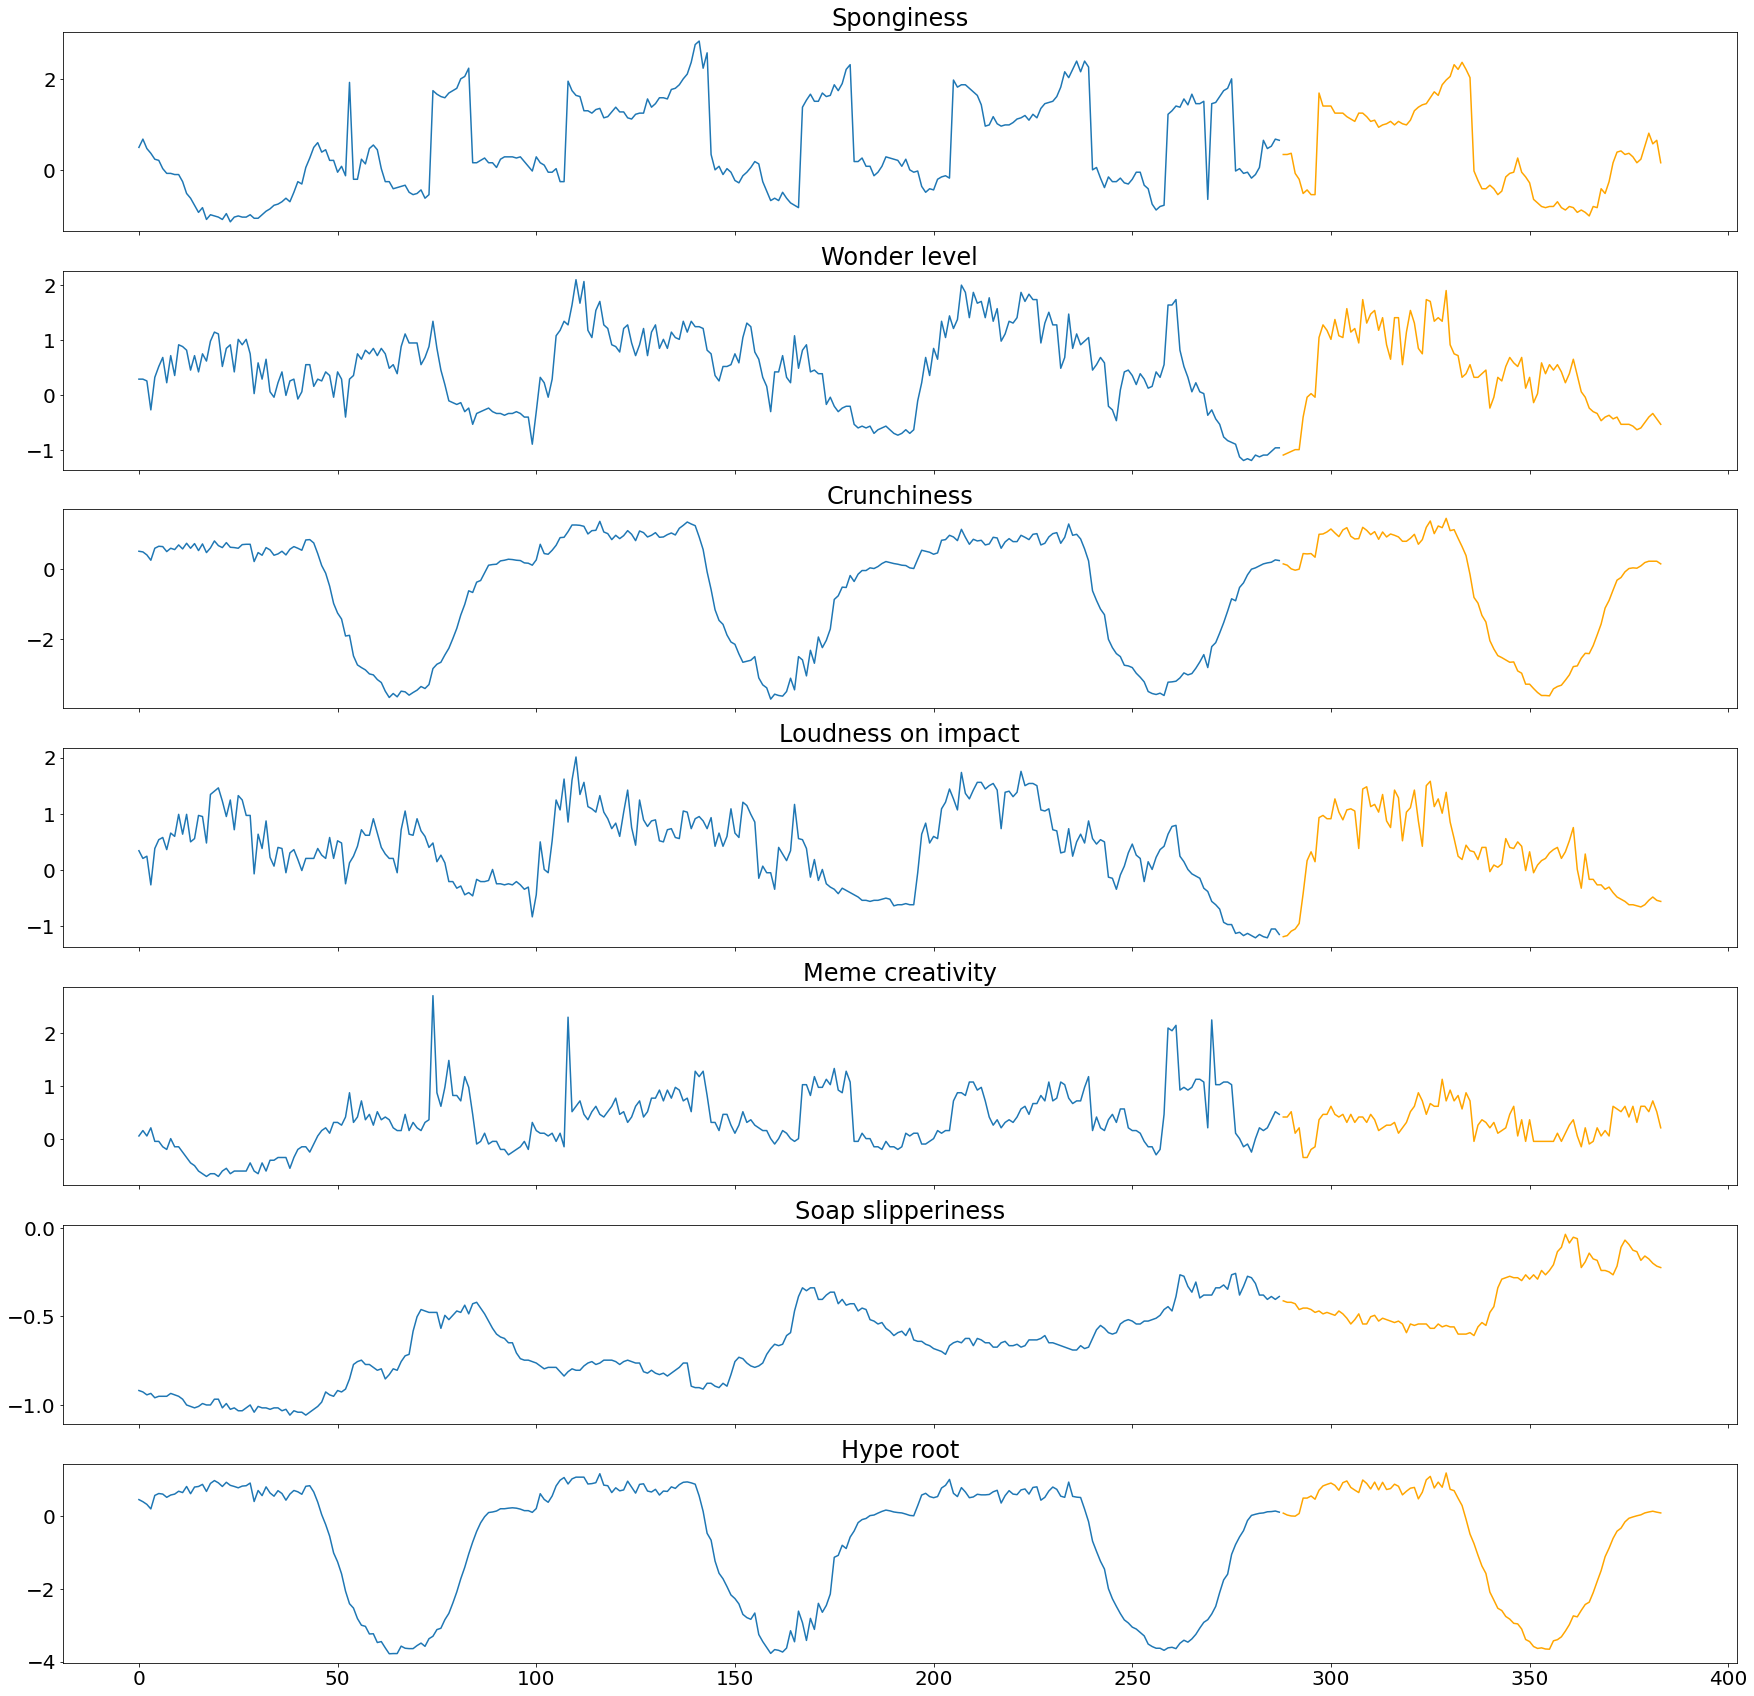

In [ ]:
X, y = train_gen.__getitem__(50000)
inspect_multivariate(X, y, df.columns, TARGET_LABELS, telescope=TELESCOPE, idx=0)

# Model

In [ ]:
def build_model(input_shape, output_shape):
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Bidirectional(tfkl.LSTM(units=input_shape[0], return_sequences=True))(input_layer)
    x = tfkl.Dropout(0.3)(x)
    x = tfkl.Bidirectional(tfkl.LSTM(units=input_shape[0]))(x)
    x = tfkl.Dropout(0.3)(x)
    
    x = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(x)
    x = tfkl.Dropout(0.3)(x)
    x = tfkl.Reshape((output_shape[0],output_shape[1]))(x)
    x = tfkl.Conv1D(filters=64, kernel_size=9, padding='same')(x)
    x = tfkl.Conv1D(filters=64, kernel_size=9, padding='same')(x)
    output_layer = tfkl.Conv1D(output_shape[1], 1, padding='same')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
input_shape = (train_gen.input_width,len(train_gen.train_features))
output_shape = (train_gen.output_width,len(train_gen.target_features))
print(input_shape)
print(output_shape)

(288, 9)
(96, 7)


In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 288, 9)]          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 288, 576)         686592    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 288, 576)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 576)              1992960   
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 672)               387744

In [ ]:
history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    steps_per_epoch= train_gen.n_batches,
    validation_steps= val_gen.n_batches,
    epochs = 200,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
        #tfk.callbacks.ReduceLROnPlateau(monitor='loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(filepath='my_model/{epoch:02d}-{val_mae:.2f}', save_weights_only=False, save_best_only=False)
    ]
).history